In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# Why do we take half of the interaction energy when the interactions are between the ions in the image cells and are not repeated.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

import numpy as np
from itertools import chain, combinations, combinations_with_replacement
from scipy.special import erfc
import pickle as pk
from time import time

# utility functions
def save_pk(data, file):
    with open(file, 'wb') as f:
        pk.dump(data, f)


In [179]:
def generate_vectors(vector_set, n, sphere=True):
    # get all possible combinations of the basis vectors
    vectors = list(chain.from_iterable(combinations_with_replacement(vector_set, i) for i in range(1, n+2)))
    # add the combinations together
    vectors = [np.sum(np.concatenate(x, axis=-1), axis=-1) for x in vectors]
    # remove the zero vectors
    vectors = np.array([x for x in vectors if not np.sum(x == 0., axis=-1) == 3])
    # remove the copies
    if sphere:
        # remove outside the radius (so it is a sphere) it doesn't make a difference to the current implementation
        r0 = n * np.sqrt(np.sum(vector_set[0]**2))
        lengths = np.sqrt(np.sum(vectors**2, axis=-1))
        mask = lengths < r0
#         print('n vectors cut: ', np.sum(mask))
        vectors = vectors[lengths < r0]
    return np.unique(vectors, axis=0)

def compute_volume(v1, v2, v3):
    cross = np.cross(v2, v3, axisa=0, axisb=0)
    box = np.sum(v1 * cross)
    return np.abs(np.squeeze(box))

def vector_sub(v1, v2):
    return np.expand_dims(v1, axis=-2) - np.expand_dims(v2, axis=-3)

def vector_add(v1, v2):
    return np.expand_dims(v1, axis=2) + np.expand_dims(v2, axis=1)

def vector_prod(v1, v2):
    return np.expand_dims(v1, axis=2) * np.expand_dims(v2, axis=1)

def compute_distances(v1, v2):
    inter_vector = vector_sub(v1, v2)
    return np.sqrt(np.sum(inter_vector**2, axis=-1))

def inner(v1, v2):
    return np.sum(v1 * v2, axis=-1)

In [180]:
#https://unlcms.unl.edu/cas/physics/tsymbal/teaching/SSP-927/Section%2001_Crystal%20Structure.pdf

basis_cell = np.array([[-0.5, 0.5, 0.5],
                       [0.5, -0.5, 0.5],
                       [0.5, 0.5, -0.5]])
print(abs(np.linalg.det(basis_cell)))
inv_cell_basis = np.linalg.inv(basis_cell)
center = np.sum(basis_cell, axis=0) / 2.
print('center: ', center)

cv1, cv2, cv3 = np.split(basis_cell, 3, axis=1)
print('primitive vectors: ', '\n', cv1, '\n', cv2, '\n', cv3)
volume = compute_volume(cv1, cv2, cv3)
print('volume', volume)
vector_set = [cv1, -cv1, cv2, -cv2, cv3, -cv3]

rv1 = 2 * np.pi * np.cross(cv2.squeeze(), cv3.squeeze()) / volume
rv2 = 2 * np.pi * np.cross(cv3.squeeze(), cv1.squeeze()) / volume
rv3 = 2 * np.pi * np.cross(cv1.squeeze(), cv2.squeeze()) / volume

reciprocal_volume = abs(np.linalg.det(np.concatenate([x[None, :] for x in (rv1, rv2, rv3)], axis=0)))
print('reciprocal volume: ', reciprocal_volume)

print('recipricol vectors: ', '\n', rv1, '\n', rv2, '\n', rv3)
vector_set_recip = [x.transpose() for x in (rv1, -rv1, rv2, -rv2, rv3, -rv3)]

n_walkers = 1000
n_el = 3

walkers = np.random.uniform(0, 1., (n_walkers, n_el, 3)) - center
talkers = walkers.dot(inv_cell_basis)
talkers = np.fmod(talkers, 1.)
talkers = np.where(talkers < 0, talkers + 1., talkers)
walkers = talkers.dot(basis_cell)
e_charges = np.array([[-1.]]).repeat(n_walkers, axis=0).repeat(n_el, axis=1)

r_atoms = np.array([[[0.25, 0.25, 0.25]]]).repeat(n_walkers, axis=0) - center
print('r_atom: ', r_atoms)

r_charges = np.array([[float(n_el)]]).repeat(n_walkers, axis=0)

walkers = np.concatenate([r_atoms, walkers], axis=1)
charges = np.concatenate([r_charges, e_charges], axis=1)
print(walkers.shape, charges.shape)


0.5
center:  [0.25 0.25 0.25]
primitive vectors:  
 [[-0.5]
 [ 0.5]
 [ 0.5]] 
 [[ 0.5]
 [-0.5]
 [ 0.5]] 
 [[ 0.5]
 [ 0.5]
 [-0.5]]
volume 0.5
reciprocal volume:  496.10042688479695
recipricol vectors:  
 [0.         6.28318531 6.28318531] 
 [6.28318531 0.         6.28318531] 
 [6.28318531 6.28318531 0.        ]
r_atom:  [[[0. 0. 0.]]

 [[0. 0. 0.]]

 [[0. 0. 0.]]

 ...

 [[0. 0. 0.]]

 [[0. 0. 0.]]

 [[0. 0. 0.]]]
(1000, 4, 3) (1000, 4)


<ipython-input-181-4afc64b84021>:9: RuntimeWarning: divide by zero encountered in true_divide
  e_e_Rs0 = q_q * np.tril(1. / e_e_distances, k=-1)


range(2, 3) [-9.500825482361575]


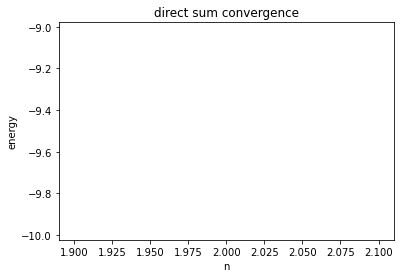

In [181]:
# show the direct sum converges 

def direct_sum(walkers, charges, n):
    lattice_vectors = generate_vectors(vector_set, n)
    
    q_q_vectors = vector_sub(walkers, walkers)
    q_q = vector_prod(charges, charges)
    e_e_distances = compute_distances(walkers, walkers)
    e_e_Rs0 = q_q * np.tril(1. / e_e_distances, k=-1)

    # compute the Rs > 0 term
    ex_walkers = vector_add(walkers, lattice_vectors[None, ...])
    tmp = walkers[..., None, None, :] - ex_walkers[:, None, ...]
    ex_distances = np.sqrt(np.sum(tmp**2, axis=-1))
    e_e_Rs1 = 0.5 * q_q * np.sum(1. / ex_distances, axis=-1)
    
    return np.mean(np.sum(e_e_Rs0 + e_e_Rs1, axis=(-1,-2)))

ns = range(2, 3)
es = []
for n in ns:
    t0 = time()
    e = direct_sum(walkers, charges, n)
    es.append(e)
    t1 = time()

print(ns, es)

fig, ax = plt.subplots()
ax.plot(np.array(ns), np.array(es))
ax.set_xlabel('n')
ax.set_ylabel('energy')
ax.set_title('direct sum convergence')
plt.show()


In [136]:
# r_vectors1 = generate_vectors(vector_set_recip, 2)
# r_vectors2 = generate_vectors(vector_set_recip, 3)
rv_before = np.concatenate([r_vectors1, r_vectors2])
rv_after = np.unique(rv_before, axis=0)
# print(len(r_vectors1), len(r_vectors2), len(rv_before), len(rv_after))
# print(r_vectors1)
# print(r_vectors2)

e_e_vectors = vector_sub(walkers, walkers)
exp = np.exp(1j * (e_e_vectors @ np.transpose(r_vectors)))

r_vectors1 = generate_vectors(vector_set_recip, 2)  # the reciprocal vectors 
r_inner1 = inner(r_vectors1, r_vectors1)  # G_s**2 

r_vectors2 = generate_vectors(vector_set_recip, 3)  # the reciprocal vectors 
r_inner2 = inner(r_vectors2, r_vectors2)  # G_s**2 

# in_before = np.concatenate([r_inner1, r_inner2])
# in_after = np.unique(in_before, axis=0)
# print(len(r_inner1), len(r_inner2), len(in_before), len(in_after))

in_before = np.concatenate([r_vectors1, r_vectors2])
in_after = np.unique(in_before, axis=0)
print(len(r_vectors1), len(r_vectors2), len(in_before), len(in_after))
# print(np.einsum('gv,nijv->nijg',r_vectors,e_e_vectors) - (e_e_vectors @ np.transpose(r_vectors)))

kappa  = 0.5 * np.sqrt(200.)
x = np.exp(- r_inner / (4 * kappa**2)) / r_inner
# print(r_inner1)
# print(r_inner2)
# print(kappa)
# print(x)

r_term1 = np.exp(- r_inner1 / (4 * kappa**2)) / r_inner1
r_term2 = np.exp(- r_inner2 / (4 * kappa**2)) / r_inner2
print(r_term1.shape, r_term2.shape)
print(r_term1.sum(), r_term2.sum())

kappa1 = 1.
kappa2 = 20.
r_term1 = np.exp(- r_inner1 / (4 * kappa1**2)) / r_inner1
r_term2 = np.exp(- r_inner1 / (4 * kappa2**2)) / r_inner1
print(r_term1.sum(), r_term2.sum())

n vectors cut:  54
n vectors cut:  164
36 92 128 92
(36,) (92,)
0.1429096396155394 0.16584849254422473
4.065950190316011e-10 0.24462240002396676


n vectors cut:  12278
n vectors cut:  12278
n vectors cut:  12278
n vectors cut:  12278
n vectors cut:  12278
[[2.27115282e-33+0.j]
 [4.30586804e+01+0.j]
 [9.12549551e+01+0.j]
 [1.30730579e+02+0.j]
 [1.64102324e+02+0.j]]


C:\Users\amwil\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


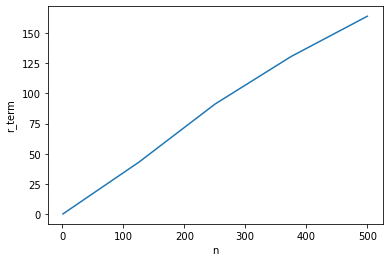

In [144]:
# testing the convergence of reciprocal sum

ns = range(2, 10)
ks = np.linspace(1, 200, 10)

values = []
n = 10
ks = np.linspace(1, 500, 5)

for k in ks:
    
    r_vectors = generate_vectors(vector_set_recip, n)  # the reciprocal vectors 
    r_inner = inner(r_vectors, r_vectors)  # G_s**2 
    e_e_vectors = vector_sub(walkers, walkers)  # l_i - l_j  (n_walkers, n_particle, n_particle)

    # RECIPROCAL TERM
    exp = np.exp(1j * (e_e_vectors @ np.transpose(r_vectors)))
    r_term = q_q * ((4 * np.pi / volume) * (np.exp(- r_inner / k) / r_inner)[None, None, None, :] * exp).sum(-1)
    r_term = r_term.sum() # exp( - G_s**2 / 4\kappa**2) / G_s**2

    values.append([r_term])
    
values = np.array(values)
print(values)
for i, t in enumerate(['r_term']):
    fig, ax = plt.subplots()
    ax.plot(ks, values[:])
    ax.set_xlabel('n')
    ax.set_ylabel(t)
    # ax.set_title('overall potential')
    plt.show()

In [182]:
# testing the convergence of reciprocal sum

ns = range(1, 10)
ks = np.linspace(1, 200, 15)

values = []
n= 15
ks = np.linspace(1, 10000, 5)
for k in ks:
    
    r_vectors = generate_vectors(vector_set_recip, n)  # the reciprocal vectors 
    r_inner = inner(r_vectors, r_vectors)  # G_s**2 
    e_e_vectors = vector_sub(walkers, walkers)  # l_i - l_j  (n_walkers, n_particle, n_particle)
    q_q = vector_prod(charges, charges)  # q_i * q_j  (n_walkers, n_particle, n_particle) prod particle charges

    # RECIPROCAL TERM
    exp = np.exp(-1j * (e_e_vectors @ np.transpose(r_vectors)))  # G_s \cdot (l_i - l_j)
    fraction = (4 * np.pi / volume) * (np.exp(- r_inner / k) / r_inner)[None, None, None, :]  # exp( - G_s**2 / 4\kappa**2) / G_s**2
    inside_the_sum = fraction * exp  
    inside_the_sum = np.real(inside_the_sum)
    assert np.sum(np.imag(inside_the_sum)) == 0.

    r_term =  (q_q * np.sum(inside_the_sum, axis=-1)).sum((-1,-2)).squeeze()  # sum over the G_s and multiply by charges

    self_interaction =  (q_q * np.diag(np.array([np.sqrt(k) / np.sqrt(np.pi)]).repeat(walkers.shape[1], axis=0)))[None, ...].sum((-1,-2)).squeeze()

    potential = r_term - self_interaction
    
    print(r_term / self_interaction)
    
    values.append([r_term, - self_interaction, potential])
    
values = np.array(values)





ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 74612 is different from 3)

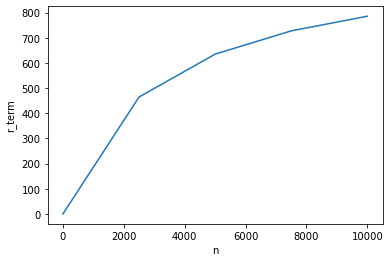

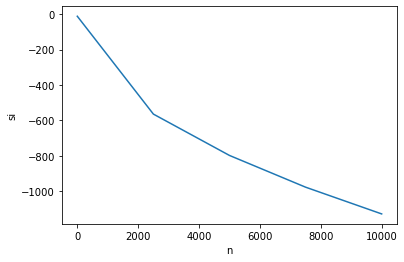

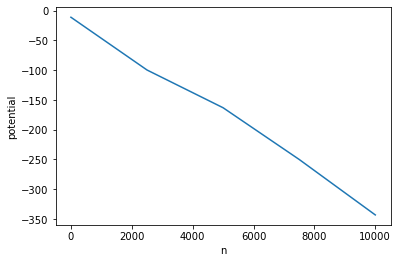

In [168]:
for i, t in enumerate(['r_term', 'si', 'potential']):
    fig, ax = plt.subplots()
    ax.plot(ks, values[:, i])
    ax.set_xlabel('n')
    ax.set_ylabel(t)
    # ax.set_title('overall potential')
    plt.show()

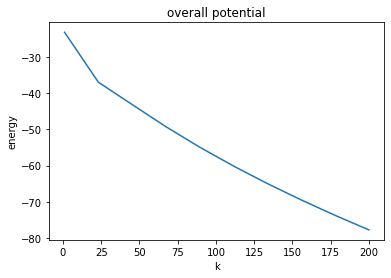

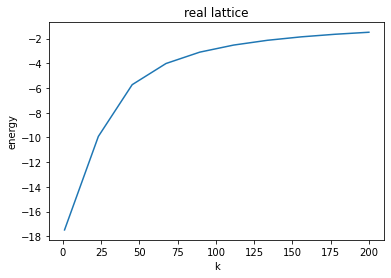

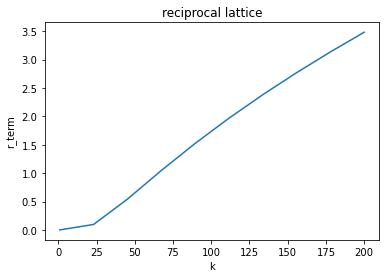

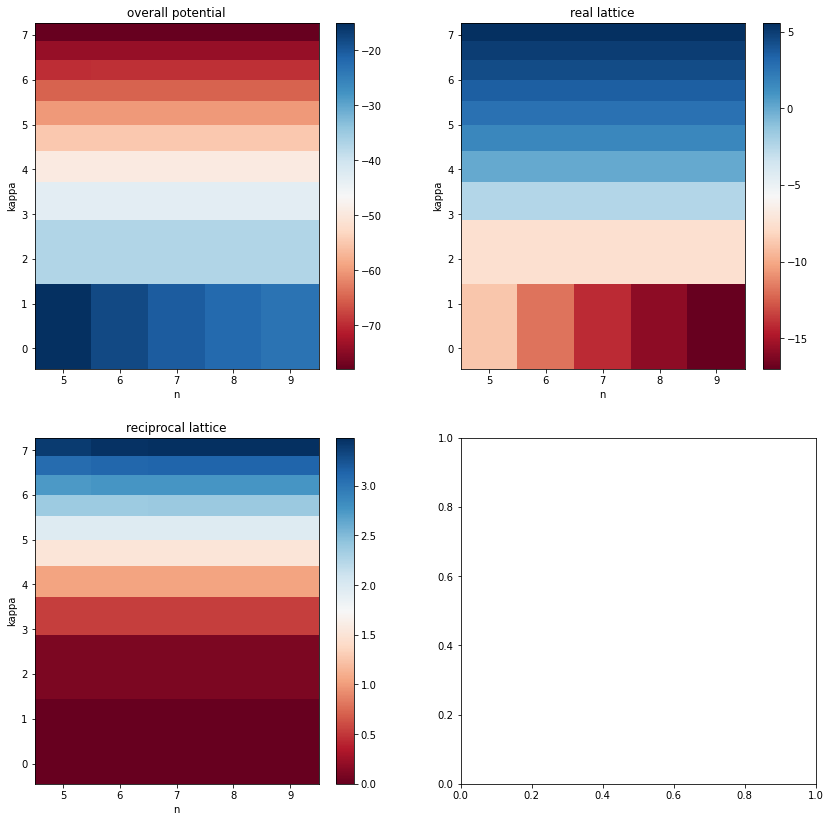

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def inner(v1, v2):
    return np.sum(v1 * v2, axis=-1)

def generate_sphere_vectors(vector_set, n, sphere=True):
    # get all possible combinations of the basis vectors
    vectors = list(chain.from_iterable(combinations_with_replacement(vector_set, i) for i in range(1, n+2)))
    # add the combinations together
    vectors = [np.sum(np.concatenate(x, axis=-1), axis=-1) for x in vectors]
    # remove the zero vectors
    vectors = np.array([x for x in vectors if not np.sum(x == 0., axis=-1) == 3])
    # remove the copies
    vectors = np.unique(vectors, axis=0)
    if sphere:
        # remove outside the radius (so it is a sphere) it doesn't make a difference to the current implementation
        r0 = n * np.sqrt(np.sum(vector_set[0]**2))
        lengths = np.sqrt(np.sum(vectors**2, axis=-1))
        vectors = vectors[lengths < r0]
    return vectors

ns = range(5, 10)
ks = np.linspace(1, 200, 10)

values = []
for n in ns:
    tmps = []
    for kappa in ks:
        kappa = 0.5 * np.sqrt(kappa)

        lattice_vectors = generate_vectors(vector_set, n)
        r_vectors = generate_vectors(vector_set_recip, n)  # the reciprocal vectors 
        r_inner = inner(r_vectors, r_vectors)  # G_s**2 
        e_e_vectors = vector_sub(walkers, walkers)  # l_i - l_j  (n_walkers, n_particle, n_particle)
        q_q = vector_prod(charges, charges)  # q_i * q_j  (n_walkers, n_particle, n_particle) prod particle charges

        ex_walkers = vector_sub(e_e_vectors, lattice_vectors[None, None, ...])
        ex_distances = np.sqrt(np.sum(ex_walkers**2, axis=-1))
        eye = ((np.eye(n_el + 1).astype(np.float64) * -1.) + 1.)[None, ...]
        e_e_real = 0.5 * q_q * np.sum(erfc(kappa * ex_distances) / ex_distances, axis=-1)

        # RECIPROCAL TERM
        exp = np.exp(1j * (e_e_vectors @ np.transpose(r_vectors)))  # G_s \cdot (l_i - l_j)
        fraction = (np.exp(- r_inner / (4 * kappa**2)) / r_inner)[None, None, None, :]  # exp( - G_s**2 / 4\kappa**2) / G_s**2
        inside_the_sum = fraction * exp  
        inside_the_sum = np.real(inside_the_sum)

        r_term = q_q * np.sum(inside_the_sum, axis=-1)  # sum over the G_s and multiply by charges

        constant = 0.5 * np.pi * q_q / (kappa**2 * volume)  # I believe this is needed if there is an overall charge on the system
        self_interaction = 0.5 * (q_q * np.diag(np.array([2 * kappa / np.sqrt(np.pi)]).repeat(walkers.shape[1], axis=0)))[None, ...]
        
        potential = e_e_real + r_term - self_interaction

        tmps.append([n, kappa,
                       np.mean(np.sum(e_e_real, axis=(-1,-2))), 
                     np.mean(np.sum(r_term, axis=(-1,-2))), 
                       np.mean(np.sum(potential, axis=(-1,-2))),])
    values.append(tmps)
    
values = np.array(values)

fig, ax = plt.subplots()
ax.plot(np.array(ks), values[-1, :, 4])
ax.set_xlabel('k')
ax.set_ylabel('energy')
ax.set_title('overall potential')
plt.show()

fig, ax = plt.subplots()
ax.plot(np.array(ks), values[-1, :, 2])
ax.set_xlabel('k')
ax.set_ylabel('energy')
ax.set_title('real lattice')
plt.show()

fig, ax = plt.subplots()
ax.plot(np.array(ks), values[-1, :, 3])
ax.set_xlabel('k')
ax.set_ylabel('r_term')
ax.set_title('reciprocal lattice')
plt.show()


# fig, ax = plt.subplots()

# titles = ['overall potential', 'real lattice', 'reciprocal lattice']
# xlabel = 'n'
# ylabel = 'kappa'
# X, Y = values[:, :, 0], values[:, :, 1]
# Zs = [values[:, :, -1], values[:, :, -3] + values[:, :, -4], values[:, :, -2]]
# Z = Zs[0]
# p = ax.pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
# ax.set_title(t)
# ax.set_xlabel('n')
# ax.set_ylabel('kappa')
# cb = fig.colorbar(p, ax=ax)

# plt.show()

fig, axs = plt.subplots(2, 2, figsize=(14,14))
axs = np.reshape(axs, (-1,))
titles = ['overall potential', 'real lattice', 'reciprocal lattice']
xlabel = 'n'
ylabel = 'kappa'
X, Y = values[:, :, 0], values[:, :, 1]
Zs = [values[:, :, -1], values[:, :, -3] + values[:, :, -4], values[:, :, -2]]

for t, Z, ax in zip(titles, Zs, axs):
    p = ax.pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
    ax.set_title(t)
    ax.set_xlabel('n')
    ax.set_ylabel('kappa')
    cb = fig.colorbar(p, ax=ax)

plt.show()


In [13]:
print(Z)
print(X)
print(Y)

[[1.48953002e-34 9.63683150e-02 5.42658411e-01 1.04623071e+00
  1.52227361e+00 1.96214783e+00 2.36741248e+00 2.74103921e+00
  3.08605021e+00 3.40526513e+00]
 [1.48953002e-34 9.63683150e-02 5.42660706e-01 1.04637412e+00
  1.52349417e+00 1.96672140e+00 2.37867680e+00 2.76276715e+00
  3.12193521e+00 3.45862551e+00]
 [1.48953002e-34 9.63683150e-02 5.42660740e-01 1.04638176e+00
  1.52362081e+00 1.96743793e+00 2.38101496e+00 2.76830264e+00
  3.13262097e+00 3.47659197e+00]
 [1.48953002e-34 9.63683150e-02 5.42660740e-01 1.04638197e+00
  1.52362898e+00 1.96751563e+00 2.38137250e+00 2.76938426e+00
  3.13513140e+00 3.48146622e+00]
 [1.48953002e-34 9.63683150e-02 5.42660740e-01 1.04638198e+00
  1.52362946e+00 1.96752318e+00 2.38142187e+00 2.76957733e+00
  3.13567644e+00 3.48270088e+00]]
[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]]
[[0.5        2.40370085 3.3623735  4.10284454 4.

In [14]:
def compute_potential(walkers, charges, kappa, n, test=False):
    lattice_vectors = generate_vectors(vector_set, n)
    r_vectors = generate_vectors(vector_set_recip, n)

    # compute the Rs0 term
    e_e_vectors = vector_sub(walkers, walkers)
    q_q = vector_prod(charges, charges)
    e_e_distances = compute_distances(walkers, walkers)
    # is half the value because only the lower half is taken
    e_e_Rs0 = q_q * np.tril(erfc(kappa * e_e_distances) / e_e_distances, k=-1)  

    # compute the Rs > 0 term
    ex_walkers = vector_add(walkers, lattice_vectors[None, ...])
    tmp = walkers[..., None, None, :] - ex_walkers[:, None, ...]
    ex_distances = np.sqrt(np.sum(tmp**2, axis=-1))
    e_e_Rs1 = 0.5 * q_q * np.sum(erfc(kappa * ex_distances) / ex_distances, axis=-1)

    # compute the constant factor
    self_interaction = 0.5 * q_q * np.diag(np.array([2 * kappa / np.sqrt(np.pi)]).repeat(walkers.shape[1], axis=0))[None, ...]
    constant = 0.5 * np.pi * q_q / (kappa**2 * volume)

    # compute the reciprocal term reuse the ee vectors
    print(e_e_vectors.shape, r_vectors.shape)
    exp = np.exp(1j * e_e_vectors @ np.transpose(r_vectors))
    r_inner = inner(r_vectors, r_vectors) 
    r_factor = (4 * np.pi / volume) * (np.exp(- r_inner / (4 * kappa**2)) / r_inner)[None, None, None, :] * exp
    r_term = 0.5 * q_q * np.real(np.sum(r_factor, axis=-1)) 
    
    average_potential = e_e_Rs0 + e_e_Rs1 + r_term
    average_potential -= constant
#     average_potential -= self_interaction
    average_potential = np.sum(average_potential, axis=(-1,-2))
    
    if test:
        print(lattice_vectors.shape, r_vectors.shape)
        print(e_e_Rs0.shape, e_e_Rs1.shape, r_term.shape)
        
    return np.mean(np.sum(e_e_Rs0, axis=(-1,-2))), np.mean(np.sum(e_e_Rs1, axis=(-1,-2))), \
np.mean(np.sum(r_term, axis=(-1,-2))), np.mean(average_potential)

# unit test
compute_potential(walkers, charges, 1., 6, test=True)

<ipython-input-14-60276dde5e50>:10: RuntimeWarning: divide by zero encountered in true_divide
  e_e_Rs0 = q_q * np.tril(erfc(kappa * e_e_distances) / e_e_distances, k=-1)


(50, 5, 5, 3) (376, 3)
(376, 3) (376, 3)
(50, 5, 5) (50, 5, 5) (50, 5, 5)


(-7.618337130438818,
 -18.082320501203423,
 9.775691897965822e-08,
 -25.70065753388532)

<ipython-input-14-60276dde5e50>:10: RuntimeWarning: divide by zero encountered in true_divide
  e_e_Rs0 = q_q * np.tril(erfc(kappa * e_e_distances) / e_e_distances, k=-1)


(50, 5, 5, 3) (62, 3)
(50, 5, 5, 3) (128, 3)
(50, 5, 5, 3) (230, 3)
(50, 5, 5, 3) (376, 3)
(50, 5, 5, 3) (574, 3)
(50, 5, 5, 3) (832, 3)
(50, 5, 5, 3) (1158, 3)
(50, 5, 5, 3) (1560, 3)
(50, 5, 5, 3) (2046, 3)
(50, 5, 5, 3) (2657, 3)
(50, 5, 5, 3) (3435, 3)
(50, 5, 5, 3) (4395, 3)
(50, 5, 5, 3) (1560, 3)
(50, 5, 5, 3) (1560, 3)
(50, 5, 5, 3) (1560, 3)
(50, 5, 5, 3) (1560, 3)
(50, 5, 5, 3) (1560, 3)


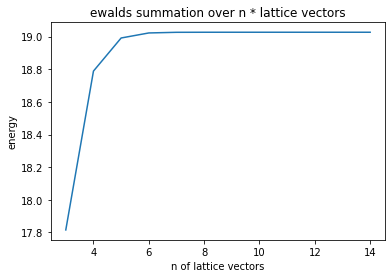

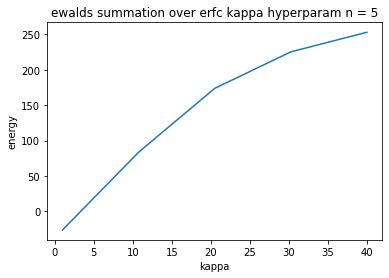

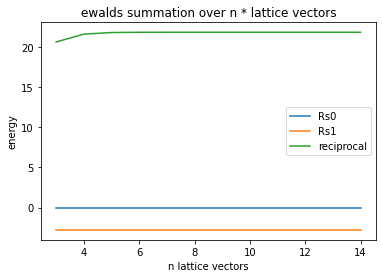

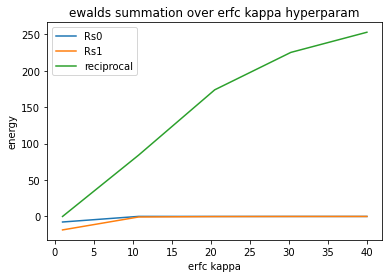

In [15]:
# plot kappa vs potential 
# plot potential vs n
# for the real and reciprocal lattice

ns = range(3, 15)
n_results = []
for n in ns:
    e_e_Rs0, e_e_Rs1, r_term, mean = compute_potential(walkers, charges, 5., n)
    n_results.append([5., n, e_e_Rs0, e_e_Rs1, r_term, mean])
n_results = np.array(n_results)
save_pk(np.array(n_results), 'n_results.pk')

kappas = np.linspace(1., 40., 5)

k_results = []
for k in kappas:
    e_e_Rs0, e_e_Rs1, r_term, mean = compute_potential(walkers, charges, k, 10)
    k_results.append([k, 10, e_e_Rs0, e_e_Rs1, r_term, mean]) 
k_results = np.array(k_results)
save_pk(np.array(k_results), 'k_results.pk')

fig, ax = plt.subplots()
ax.plot(n_results[:, 1], n_results[:, -1])
ax.set_xlabel('n of lattice vectors')
ax.set_ylabel('energy')
ax.set_title('ewalds summation over n * lattice vectors')
plt.show()

fig, ax = plt.subplots()
ax.plot(k_results[:, 0], k_results[:, -1])
ax.set_xlabel('kappa')
ax.set_ylabel('energy')
ax.set_title('ewalds summation over erfc kappa hyperparam n = 5')
plt.show()

fig, ax = plt.subplots()
for i, l in enumerate(['Rs0', 'Rs1', 'reciprocal']):
    ax.plot(n_results[:, 1], n_results[:, i+2], label=l)
    ax.set_xlabel('n lattice vectors')
    ax.set_ylabel('energy')
    ax.set_title('ewalds summation over n * lattice vectors')
ax.legend()
plt.show()

fig, ax = plt.subplots()
for i, l in enumerate(['Rs0', 'Rs1', 'reciprocal']):
    ax.plot(k_results[:, 0], k_results[:, i+2], label=l)
    ax.set_xlabel('erfc kappa')
    ax.set_ylabel('energy')
    ax.set_title('ewalds summation over erfc kappa hyperparam')
ax.legend()
plt.show()


In [16]:
ns = range(4, 10)
kappas = np.linspace(5, 100, 10)

nk_results = []
for n in ns:
    k_results = []
    for k in kappas:
        e_e_Rs0, e_e_Rs1, r_term, mean = compute_potential(k, n)
        results = [n, k, e_e_Rs0, e_e_Rs1, r_term, mean]
        k_results.append(results) 
        print(results)
        
    nk_results.append(k_results)
    
nk_results = np.array(nk_results)
print(nk_results.shape)


TypeError: compute_potential() missing 2 required positional arguments: 'kappa' and 'n'

In [ ]:


fig, axs = plt.subplots(2, 2, figsize=(14,14))
X, Y, Z = nk_results[:,:,0], nk_results[:,:,1], nk_results[:,:,-1]
p = axs[0,0].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
axs[0,0].set_title('overall potential')
axs[0,0].set_xlabel('n lattice vectors')
axs[0,0].set_ylabel('kappa')
cb = fig.colorbar(p, ax=axs[0,0])
# plt.show()

# fig, ax = plt.subplots()
X, Y, Z = nk_results[:,:,0], nk_results[:,:,1], nk_results[:,:,-4]
p = axs[1,0].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
axs[1,0].set_title('Rs0')
axs[1,0].set_xlabel('n lattice vectors')
axs[1,0].set_ylabel('kappa')
cb = fig.colorbar(p, ax=axs[1,0])
# plt.show()

# fig, ax = plt.subplots()
X, Y, Z = nk_results[:,:,0], nk_results[:,:,1], nk_results[:,:,-3]
p = axs[0,1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
axs[0,1].set_title('Rs1')
axs[0,1].set_xlabel('n lattice vectors')
axs[0,1].set_ylabel('kappa')
cb = fig.colorbar(p, ax=axs[0,1])
# plt.show()

# fig, ax = plt.subplots()
X, Y, Z = nk_results[:,:,0], nk_results[:,:,1], nk_results[:,:,-2]
p = axs[1,1].pcolor(X, Y, Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max(), shading='auto')
axs[1,1].set_title('reciprocal term')
axs[1,1].set_xlabel('n lattice vectors')
axs[1,1].set_ylabel('kappa')
cb = fig.colorbar(p, ax=axs[1,1])
plt.show()

In [ ]:
# ex_walkers = vector_add(walkers, lattice_vectors[None, ...]).reshape(n_walkers, -1, 3)
#     ex_distances = compute_distances(walkers, ex_walkers)
#     e_e_Rs1 = 0.5 * np.sum(erfc(kappa * ex_distances) / ex_distances, axis=(-1, -2))
#     print(e_e_Rs1.shape)
    
fig, ax = plt.subplots()
x = np.linspace(-50, 50, 100)
ax.plot(x, erfc(x))
ax.set_xlabel('x')
ax.set_ylabel('erfc(x)')
ax.set_title('erfc function')

fig, ax = plt.subplots()
x = np.linspace(-5, 5, 100)
ax.plot(x, erfc(x))
ax.set_xlabel('x')
ax.set_ylabel('erfc(x)')
ax.set_title('erfc function')

fig, ax = plt.subplots()
x = np.linspace(-5, 5, 100)
ax.plot(x, erfc(x) / x)
ax.set_xlabel('x')
ax.set_ylabel('erfc(x) / x')
ax.set_title('erfc function / distance')

In [ ]:
kappa = 1.
sums = []
for n in range(5, 15):
    lattice_vectors = generate_vectors(vector_set, n)
    n_l = len(lattice_vectors)
    lattice_vectors = np.unique(lattice_vectors, axis=0)
    print(n_l, len(lattice_vectors))
    ex_walkers = vector_add(walkers, lattice_vectors[None, ...])
    ex_walkers = np.reshape(ex_walkers, (n_walkers, -1, 3))
    ex_distances = compute_distances(walkers, ex_walkers)
    e_e_Rs1 = 0.5 * np.sum(erfc(kappa * ex_distances) / ex_distances, axis=(-1, -2))
    print(n, np.mean(e_e_Rs1), len(lattice_vectors))
    ex_distances = np.reshape(ex_distances, (n_walkers, n_el, n_el, len(lattice_vectors)))
#     fig, ax = plt.subplots()
    x = np.sort(1. / np.mean(ex_distances, axis=(0, 1, 2)))[::-1]
#     ax.plot(range(len(lattice_vectors)), x, label='rs')
#     ax.plot(range(len(lattice_vectors)), erfc(1./x), label='erfc')
#     ax.plot(range(len(lattice_vectors)), x * erfc(1./x), label='erfc')
    

#     ax.set_xlabel('convergence of 1/r')
#     ax.set_ylabel('1/r')
#     ax.set_title('r')
    
    sums.append([n, np.mean(np.sum(erfc(kappa * ex_distances), axis=(-1, -2))), np.mean(np.sum(1. / ex_distances, axis=(-1,-2)))])

sums = np.array(sums)

fig, ax = plt.subplots()
ax.plot(sums[:,0], sums[:,1], label='erfc')

fig, ax = plt.subplots()
ax.plot(sums[:,0], sums[:,2], label='1/x')

    # print(np.mean(ex_distances, axis=(0, 1, 2)))

In [ ]:
a = np.array([[1, 0, 0], [1, 0, 0], [1.5, 0.5, 0.], [1.5, 0.5, 0.1], [2, 3, 4]])
np.unique(a, axis=0)
